## Purpose: Train a model able to find matching fields in different documents

https://medium.com/@dhifallah.othmen/mesurer-la-similarit%C3%A9-s%C3%A9mantique-entre-phrases-avec-python-d08bf409200d
https://www.youtube.com/watch?v=ZeQgNhc0vag&ab_channel=KnowledgeCenter
https://www.youtube.com/playlist?list=PLhWB2ZsrULv-wEM8JDKA1zk8_2Lc88I-s

### 1 : Libraries import

In [2]:
import os
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
from langdetect import detect
from joblib import dump, load
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn import tree

### 2 : Definition of words pre-processing functions

In [3]:
def stem(list_text):
    """ Stemming """
    stemmer = nltk.stem.porter.PorterStemmer()
    return [stemmer.stem(token) for token in list_text]

def remove_punctuation(list_text):
    """ Removing punctuation """
    remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
    return [token.translate(remove_punctuation_map) for token in list_text]

def delete_stop_words(list_text):
    """ Deleting not significant words """
    stop_words = stopwords.words('french') + stopwords.words('english')
    return [" ".join([word for word in token.split() if word not in stop_words]) for token in list_text]

def pre_process_tokenizer(list_text):
    """ Pre-processing by chaining transformations : stemming, removing punctuation, deleting stop words """
    return delete_stop_words(remove_punctuation(stem(list_text)))


### 3 : Building of a dictionnary containing, for french and english distinctively, training examples (key = df), corpus (key = corpus), base (key = base), vector projected in the base (key = X), label encoder (key = label_encoder), Y (key = Y)

In [4]:
df_csv_matching = pd.read_csv('matching_train.csv')
df_csv_matching['Language_client'] = df_csv_matching['column_client'].apply(detect)
df_csv_matching = df_csv_matching[['Language_client', 'column_client', 'column_daiteo']] # Reordering columns

In [5]:
dict_matching = {}

for language in ['en', 'fr']:
    dict_matching[language] = {}
    dict_matching[language]['df'] = df_csv_matching.loc[df_csv_matching['Language_client'] == language]
    dict_matching[language]['corpus'] = dict_matching[language]['df']['column_client'].tolist()
    dict_matching[language]['base'] = CountVectorizer()
    dict_matching[language]['base'].fit(pre_process_tokenizer(dict_matching[language]['corpus']))
    dict_matching[language]['X'] = pd.DataFrame(dict_matching[language]['base'].transform(pre_process_tokenizer(dict_matching[language]['df']['column_client'].tolist())).toarray(), columns = dict_matching[language]['base'].get_feature_names())
    dict_matching[language]['label_encoder'] = LabelEncoder()
    dict_matching[language]['label_encoder'].fit(dict_matching[language]['df']['column_daiteo'])
    dict_matching[language]['Y'] = pd.Series(dict_matching[language]['label_encoder'].transform(dict_matching[language]['df']['column_daiteo']))

In [6]:
dict_matching['en']['base'].get_feature_names()

['id', 'identifi', 'item', 'numb', 'product']

In [7]:
dict_matching['fr']['base'].get_feature_names()

['coloris',
 'couleur',
 'dimens',
 'dimension',
 'dimensions',
 'identifi',
 'masse',
 'numéro',
 'poids',
 'product',
 'produit',
 'référence',
 'teintes']

### 4 : Models training (Decision tree classifier), for french and english distinctively

In [8]:
for language in ['en', 'fr']:
    dict_matching[language]['model'] = DecisionTreeClassifier(random_state = 0)
    dict_matching[language]['model'].fit(dict_matching[language]['X'], dict_matching[language]['Y'])

### 5 : Models saving

In [9]:
def save_model_base_labelEncoder(saving_directory, dict_language):
    os.mkdir(saving_directory)
    os.chdir(saving_directory)
    dump(dict_language, 'save')
    os.chdir('.\..')

for language in ['en', 'fr']:
    save_model_base_labelEncoder('save_03-10-2020_' + str(language), dict_matching[language])

### 6 : Model evaluation and understanding

#### 6.1 : Score of model on training examples

In [10]:
for language in ['en', 'fr']:
    print("Score on training set in " + str(language) + ": " + str(dict_matching[language]['model'].score(dict_matching[language]['X'], dict_matching[language]['Y'])))

Score on training set in en: 1.0
Score on training set in fr: 1.0


#### 6.2 : Misclassified training examples

Text(0.5, 1.0, 'CONFUSION MATRIX FOR CLASSIFICATION TASK IN FR')

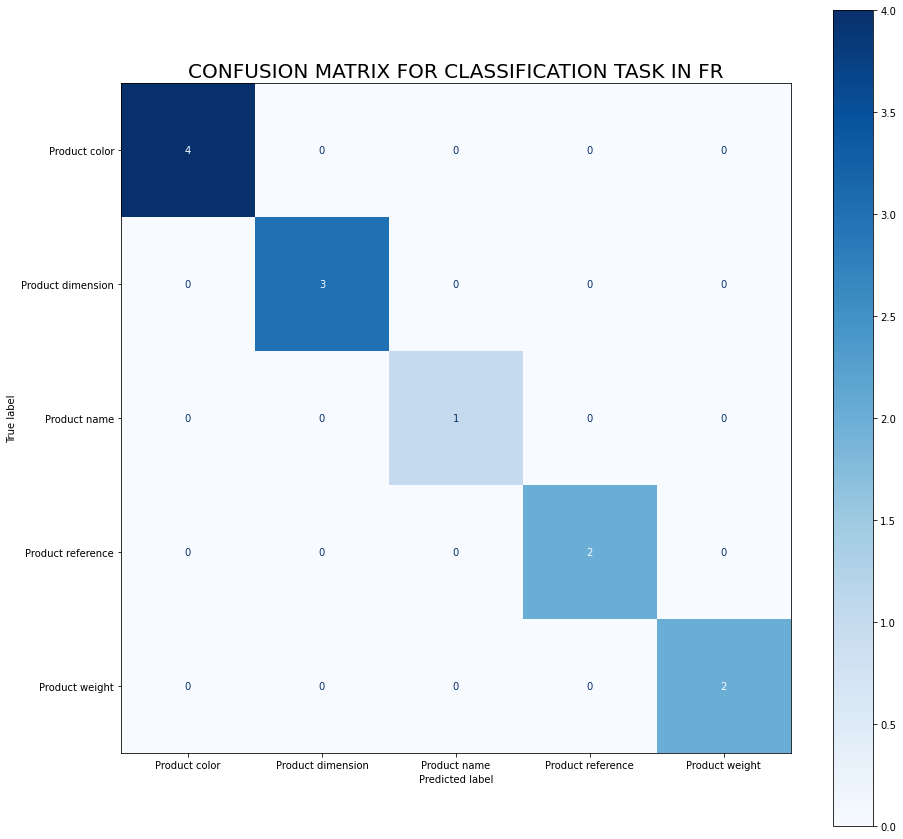

In [11]:
language = 'fr'

fig, ax = plt.subplots(figsize=(15,15))
disp = plot_confusion_matrix(dict_matching[language]['model'], dict_matching[language]['X'], dict_matching[language]['Y'], display_labels = dict_matching[language]['label_encoder'].classes_, cmap = plt.cm.Blues, normalize = None, ax = ax)
disp.ax_.set_title('CONFUSION MATRIX FOR CLASSIFICATION TASK IN ' + language.upper() , size = 20)

#### 6.3 : Words significance plotting for classification

In [12]:
for language in ['en', 'fr']:
    dict_matching[language]['df_features_importance'] = pd.DataFrame({'Features' : dict_matching[language]['base'].get_feature_names(), 'Importance' : dict_matching[language]['model'].feature_importances_})
    dict_matching[language]['df_features_importance'] = dict_matching[language]['df_features_importance'].sort_values(by = 'Importance', ascending = False)

Text(0.5, 1.0, 'WORDS SIGNIFICANCE FOR CLASSIFICATION IN FR')

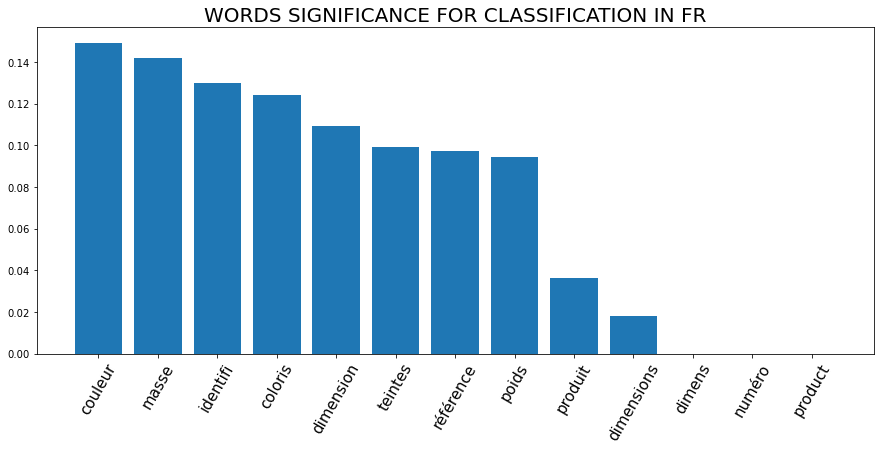

In [13]:
language = 'fr'

plt.figure(figsize=(15,6))
plt.bar([*range(len(dict_matching[language]['df_features_importance']))], dict_matching[language]['df_features_importance']['Importance'], tick_label = dict_matching[language]['df_features_importance']['Features'])
plt.xticks(rotation = 60, size = 15)

plt.title('WORDS SIGNIFICANCE FOR CLASSIFICATION IN ' + language.upper(), size = 20)